# Create the final joint light curve plots


**Author:** Hannu Parviainen<br>
**Last edited:** 27.4.2022

In [1]:
%matplotlib inline

In [2]:
import seaborn as sb
from numpy.random import permutation
from numpy import array, zeros, median, percentile, concatenate, where, argsort
from matplotlib.pyplot import subplots, setp

from pytransit.orbits import fold, epoch
from pytransit.utils.downsample import downsample_time_1d

from src import AAPGW, FinalLPF, read_mcmc

In [3]:
lpf = FinalLPF('b',  downsampling={'croll':10, 'lbt':10, 'spitzer':10})

In [4]:
df = read_mcmc('results/03b_fin_emission_and_constrained_ev.nc').iloc[:,:-1]
pvp = permutation(df.values)[:1500]

In [21]:
def plot_joint_lcs(lpf, pv=None, context='notebook', font_scale=1.0, figsize=(13,12), lsize=None, ms=None):
    yoff = 5e-3
    yoffsets = (yoff * array([1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0])).cumsum()
    colids = [0, 1, 1, 2, 3, 4, 4, 4, 5, 6, 6, 6, 7]
    poffset = [0, 1, 1, 0, 0, 0, 0, 0, 0, 0]

    
    if pv.ndim == 1:
        t0, p = pv[[0, 1]]
        mpv = pv
        fm = lpf.transit_model(pv)
        fmem, fmep = None, None
        bl = lpf.baseline(pv)
        fobs = lpf.ofluxa / bl
    else:
        t0, p = median(pv[:,:2], 0)
        mpv = median(pv, 0)
        fm, fmem, fmep = percentile(lpf.transit_model(pv), [50, 16, 84], axis=0)
        fobs = median(lpf.ofluxa / lpf.baseline(pv), axis=0)
            
    gpf = zeros(lpf.ofluxa.size)
    for llm in lpf._lnlikelihood_models:
        if 'Celerite' in llm.__class__.__name__:
            gpf[llm.mask] = llm.predict_baseline(mpv)[llm.mask] - 1.0

        elif 'George' in llm.__class__.__name__:
            t = llm.predict_baseline(mpv) - 1.0
            for sl in llm.slices:
                gpf[sl] = t[sl]
            
    with sb.plotting_context('paper', font_scale=font_scale):
        fig, ax = subplots(figsize=figsize)

        # CHEOPS
        # ======
        ctime = concatenate([lpf.timea[lpf.lcslices[i]] for i in where(lpf.pbids==0)[0]])
        cflux = concatenate([fobs[lpf.lcslices[i]] for i in where(lpf.pbids==0)[0]])

        phase = fold(ctime, p, t0 + 0.18) + 0.18
        sids = argsort(phase)
        bp, bf, be = downsample_time_1d(phase[sids], cflux[sids], 10 / 60 / 24)
        ax.errorbar(bp, bf, be, fmt='.', c="C0", ms=ms)
        ax.plot(phase[sids], fm[sids], 'k')

        # TESS
        sl = lpf.lcslices[8]
        phase = fold(lpf.timea[sl], p, t0 + 0.18) + 0.18
        sids = argsort(phase)
        bp, bf, be = downsample_time_1d(phase[sids], fobs[sl][sids] - gpf[sl][sids], 10 / 60 / 24)
        ax.plot(bp, bf + yoffsets[0], '.', c="C1",zorder=-1, ms=ms)
        ax.plot(phase[sids], fm[sl][sids] + yoffsets[0], 'k-')


        # LBT and Spitzer
        for i, sl in enumerate(lpf.lcslices[9:]):
            ep = epoch(lpf.timea[sl].mean(), t0, p)
            tc = t0 + ep * p

            ax.plot(lpf.timea[sl] - tc + poffset[i] * p, fobs[sl] - gpf[sl] + yoffsets[i+1], '.', c=f"C{colids[i+2]}", ms=ms)
            ax.plot(lpf.timea[sl] - tc + poffset[i] * p, fm[sl] + yoffsets[i+1], 'k')
            if fmem is not None:
                ax.fill_between(lpf.timea[sl] - tc + poffset[i] * p, 
                                fmem[sl] + yoffsets[i+1], 
                                fmep[sl] + yoffsets[i+1], 
                                fc=f"C{colids[i+2]}", alpha=0.5)

        ax.text(-0.1, 1.0 + 6.1*yoff, 'Spitzer 4.5 $\mu$m (2019)', ha='right', size=lsize)
        ax.text(0.42, 1.0 + 6.1*yoff, 'Spitzer 4.5 $\mu$m (2014)', ha='right', size=lsize)
        ax.text(-0.1, 1.0 + 4.1*yoff, 'Spitzer 3.6 $\mu$m (2019)', ha='right', size=lsize)
        ax.text(0.42, 1.0 + 4.1*yoff, 'Spitzer 3.6 $\mu$m (2014)', ha='right', size=lsize)
        ax.text(0.42, 1.0 + 3*yoff, 'CFHT Ks', ha='right', size=lsize)
        ax.text(0.42, 1.0 + 2*yoff, 'LBT H', ha='right', size=lsize)
        ax.text(-0.1, 1.0, 'TESS', ha='right', size=lsize)
        ax.text(0.42, 1.0, 'CHEOPS', ha='right', size=lsize)

        setp(ax, xlim=(-0.75, 0.84), ylabel='Normalised flux')
        setp(ax, xlabel='Time - t$_0$ [d]')

        sb.despine(fig, offset=15)
        fig.tight_layout()
        return fig

## Version for the screen

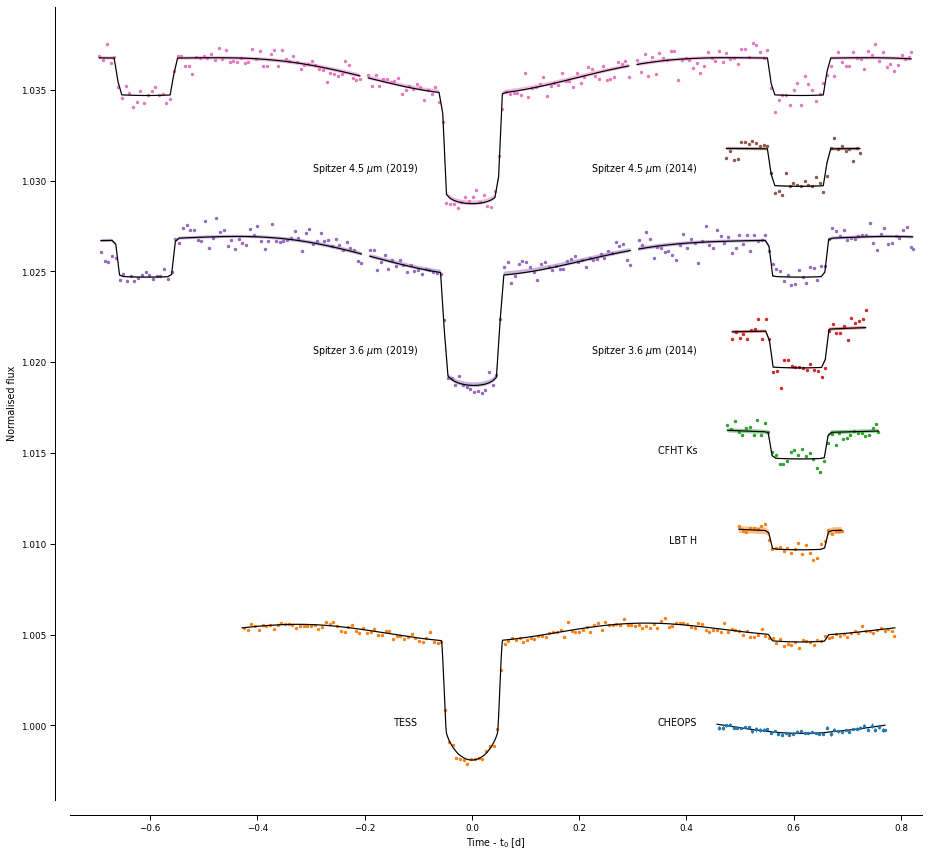

In [23]:
fig = plot_joint_lcs(lpf, pv=pvp)

## Version for the paper

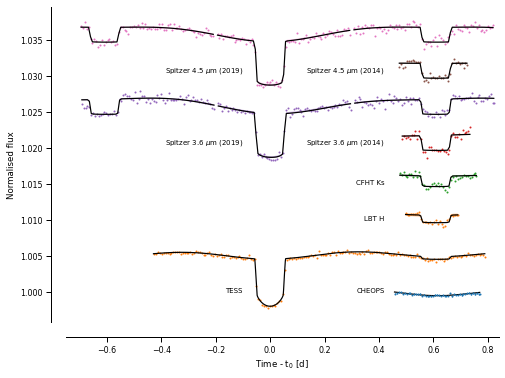

In [25]:
fig = plot_joint_lcs(lpf, pv=pvp, context='paper', figsize=(AAPGW, 0.75*AAPGW), font_scale=0.9, lsize=7, ms=2)
fig.savefig('plots/kelt-1b-final-lc.pdf')

---

<center>&copy;2022 Hannu Parviainen</center>